In [1]:
import os
import pickle

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from pyemd import emd

from utils import get_hash
from utils import Featurizer
from utils import plot_confusion_matrix

## Reading Data

We will be reading modeling and test data that were prepared using a random split during the preprocessing phase.  
The training set represents 70% from the instances in the original data.  
We saved 10% to generate landmarks (student answers that will be combined to reference answers) in order to create features.  
Because the data is small, we will be using a 10-fold evaluation strategy.  
The test set contrains the remaining 20% of the orignal data.

In [2]:
train = pd.read_csv(os.path.join('munge', 'train.csv'))
print('Found %d instances in training set.' %len(train))
test = pd.read_csv(os.path.join('munge', 'test.csv'))
print('Found %d instances in test set.' %len(test))

Found 628 instances in training set.
Found 180 instances in test set.


Landmarks are oservations from the training set, a mixture of student answers and reference answers.  
We will be using those landmarks to create similarity features using pre-trained word embeddings.    
The embeddings in the landmark dataset have already been computed during the preprocessing phase.

In [3]:
landmarks = pd.read_csv(os.path.join('munge', 'landmarks.txt'), sep="\t")
landmarks['embedding'] = landmarks['embedding'].apply(lambda x : list(map(float, x.split(','))))
print('Found %d landmarks.' %len(landmarks))
landmarks.head()

Found 318 landmarks.


,pd_hash,qu_hash,label,answer,embedding
0,1e16b87c67,a149b85e97,0,Since the windshield exerts a force on the mos...,"[0.07263770470252404, 0.05414287860576923, 0.0..."
1,1e16b87c67,a149b85e97,0,The action is the windshield squashing the mo...,"[0.0673675537109375, 0.05970594618055555, 0.00..."
2,1e16b87c67,a149b85e97,0,The force exerted by the windshield on the mos...,"[0.043080647786458336, 0.06363932291666667, 0...."
3,1e16b87c67,a149b85e97,0,The force exerted by the windshield on the mos...,"[0.05015497622282609, 0.07818868885869565, 0.0..."
4,0c186b934b,af26c01763,0,The forces acting on the puck while it is betw...,"[0.011857874253216912, 0.04596191294053022, 0...."


## Feature Engineering

Fist, we need a featurizer to perform text actions like generating embeddings and computing different similarity scores between phrases.  
This will help measure contextual similarity between a student answer and a reference answer for example.

In [4]:
# Create a featurizer object that converts a phrase into embedding vector using pre-trained word2vec
emb_file = os.path.join('data', 'GoogleNews-vectors-negative300.bin')
featurizer = Featurizer(emb_file)

INFO: Loading word vectors...
INFO: Done! Using 3000000 word vectors from pre-trained word2vec.


Then, we may need a function that creates some features given an instance of a student answer to question:
* Cosine similarities to all landmarks using the doc2vec embeddings
* Ratio of tokens in each landmark that are not in the student answer
* Ratio of tokens in student answer that are not in each landmark
* Number of tokens in common between the student answer and each landmark
* Flag to indicate wether of not the student answer contains no context (zero embedding)

In [5]:
def get_features(landmarks, obs):
    """"Create all features to represent an observation.
    
    Args:
        landmarks (dataframe) landmark instances from preprocessing
        obs : (series) one instance in train or test dataframe
    
    Returns:
        features : a numpy vector with float numbers
    """
        
    # Get observation values
    pd_hash = get_hash(obs['problem_description'])
    qu_hash = get_hash(obs['question'])
    emb = featurizer.doc2vec(obs['answer'])
        
    # Landmark of different question will get zero similarity (default)
    qu_land = landmarks.copy()
    qu_land['similarity'] = 0 # Compute cosine similarity with landmark
    qu_land['asym_diff_left'] = 0 # asymmetric difference between answer and landmark
    qu_land['asym_diff_right'] = 0 # asymmetric diffence between landmark and answer
    qu_land['word_match'] = 0 # word match between landmark and answer
    #qu_land['wmdist'] = 0 # world mover's distance between landmark and answer

    # Compute similarity when embedding is not zero and landmark from same question
    if norm(emb)!=0:
        # Get index of landmarks with same problem  and question 
        idx = qu_land[(qu_land['pd_hash']==pd_hash) & (qu_land['qu_hash']==qu_hash)].index
        # Compute the direct similarity with these landmarks
        qu_land.loc[idx, 'similarity'] = qu_land.loc[idx, 'embedding'].apply(lambda x : featurizer.cossim_from_emb(emb, np.array(x)))
        # Compute the asymmetric difference between answer and landmark
        qu_land.loc[idx, 'asym_diff_left'] = qu_land.loc[idx, 'answer'].apply(lambda x : featurizer.asym_diff(obs['answer'], x))
        # Compute the asymmetric difference between landmark and answer
        qu_land.loc[idx, 'asym_diff_right'] = qu_land.loc[idx, 'answer'].apply(lambda x : featurizer.asym_diff(x, obs['answer']))
        # Compute the word match ratio between answer and landmark
        qu_land.loc[idx, 'word_match'] = qu_land.loc[idx, 'answer'].apply(lambda x : featurizer.word_match(obs['answer'], x))
        # Compute the world mover's distance between answer and landmark
        #qu_land.loc[idx, 'wmdist'] = qu_land.loc[idx, 'answer'].apply(lambda x : featurizer.wmdist(obs['answer'], x))

    # Features will be all similarity measures to landmarks    
    features = np.concatenate((qu_land['similarity'],
                               qu_land['asym_diff_left'],
                               qu_land['asym_diff_right'],
                               qu_land['word_match']))
     
    # Add feature to indicate wether or not observation embedding was zero
    if norm(emb)==0:
        features = np.append(1, features)
    else:
        features = np.append(0, features)
        
    """# Add a feature to indicate similarity to question
    sim_to_qu = featurizer.cossim_from_phrase(obs['answer'], obs['question'])
    features = np.append(sim_to_qu, features)

    # Add a feature to indicate similarity to problem description
    sim_to_pd = featurizer.cossim_from_phrase(obs['answer'], obs['problem_description'])
    features = np.append(sim_to_pd, features)"""
    
    return features

Now, we can extract features for all training and test instances and get their labels for training and evaluation.

In [6]:
# Function to featurize a dataset
def kernel_matrix(data, landmarks):
    features = np.array(list(data.apply(lambda x : get_features(landmarks, x), axis=1)))
    return(features)

# Prepare features
X_train = kernel_matrix(train, landmarks)
X_test = kernel_matrix(test, landmarks)

# Prepare labels
y_train = np.array(train['label'])
y_test = np.array(test['label'])

print('Number of features: {}'.format(X_train.shape[1]))
print('number of labels: {}'.format(np.unique(y_train).size))

Number of features: 1273
number of labels: 4


## Model Training

Because the training set is quite small, we will not be using any complex non linear model as it may increase the risk of overfitting.  
Tree based models like RandomForest and Xgboost are not well-suited especially if the number of features is high and is supposed to increase with more landmark answers coming from teachers and students.  
Linear models combined to kernel features can lead to interesting results when the dataset is small.  
We will then be using a penalized multinomial logistic regression (softmax) that we will be tuning using a 10-fold cross-validation strategy.

In [9]:
from sklearn.model_selection import GridSearchCV
import time

print("Fitting the classifier to the training set...")
t0 = time.time()

param_grid = {'C': [1e-1, 3e-1, 1, 3, 1e1, 3e1, 1e2, 3e2]}
clf = GridSearchCV(LogisticRegression(random_state=22, solver='lbfgs', max_iter=1000, multi_class='multinomial'),
                   param_grid,
                   cv=10,
                   verbose=1,
                   n_jobs=-1)

clf = clf.fit(X_train, y_train)
model = clf.best_estimator_
if not os.path.exists('model'):
        os.makedirs('model')
pickle.dump(model, open(os.path.join('model', 'multinomial_lr.pkl'), 'wb'))

print("Training took %.3fs" %(time.time() - t0))
print("Best score on cross-validation: %.2f" %clf.best_score_)
print("Best estimator found by grid search:")
print(model)

Fitting the classifier to the training set...
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   33.4s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Training took 33.634s
Best score on cross-validation: 0.58
Best estimator found by grid search:
LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=22, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


## Model Evaluation

Let's run predictions on all instances in the test set.  
We can measure the accuracy of these predictions and the F1-score accross the different classes.

In [10]:
model.predict(X_test)

array([0, 3, 0, 0, 1, 3, 0, 1, 1, 0, 2, 0, 1, 1, 2, 3, 3, 0, 3, 1, 0, 0,
       0, 3, 3, 0, 1, 0, 1, 3, 2, 3, 3, 3, 3, 0, 0, 1, 3, 3, 3, 0, 0, 2,
       0, 3, 2, 0, 3, 0, 3, 2, 0, 0, 0, 1, 0, 3, 1, 0, 3, 0, 3, 0, 0, 0,
       0, 0, 0, 1, 3, 1, 0, 3, 1, 1, 0, 1, 0, 1, 0, 3, 0, 2, 0, 2, 0, 0,
       3, 0, 2, 3, 1, 3, 1, 0, 0, 0, 2, 0, 1, 3, 0, 2, 0, 1, 0, 0, 0, 0,
       1, 3, 1, 1, 2, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 0, 0, 0, 2, 2, 2, 0,
       3, 2, 1, 0, 3, 0, 1, 1, 0, 0, 0, 3, 1, 0, 0, 1, 3, 0, 1, 3, 0, 0,
       0, 0, 1, 3, 1, 2, 3, 0, 3, 0, 1, 0, 3, 0, 1, 1, 1, 3, 0, 2, 0, 0,
       2, 0, 3, 0])

### Accuracy

In [11]:
# Accuracy on training set
y_hat_train = model.predict(X_train)
acc = np.round(np.mean(y_train == y_hat_train),2)
print("Performance on training set")
print('Accuracy: {}'.format(acc))

Performance on training set
Accuracy: 0.75


In [12]:
# Accuracy on 10-fold cross-validation
print("Performance on 10-fold cross-valiation")
print('Accuracy: {}'.format(round(clf.best_score_,2)))

Performance on 10-fold cross-valiation
Accuracy: 0.58


In [13]:
# Accuracy on test set
y_hat_test = model.predict(X_test)
acc = np.round(np.mean(y_test == y_hat_test),2)
print("Performance on test set")
print('Accuracy: {}'.format(acc))

Performance on test set
Accuracy: 0.59


We can notice some overfitting to the training data.  
This can be solved by getting more data or reducing the number of complex features.  
What is important is the stability we get from the cross-validation strategy (very close performance to test set).  
We can use the 10-fold cv to tune the model and estimate the performance on final test instances.

### Confusion Matrix

The confusion matrix helps understand the performance of the model by comparing the predictions on test set to actual labels.

In [14]:
# Prepare class names for display
class_dict = {0:'correct', 1:'correct_but_incomplete', 2:'contradictory', 3:'incorrect'}
class_ids = list(np.unique(y_test))
class_names = [class_dict[cid] for cid in class_ids]

Confusion matrix, without normalization
[[53  9  4  8]
 [15 17  1  5]
 [ 1  4  8  4]
 [10  7  6 28]]


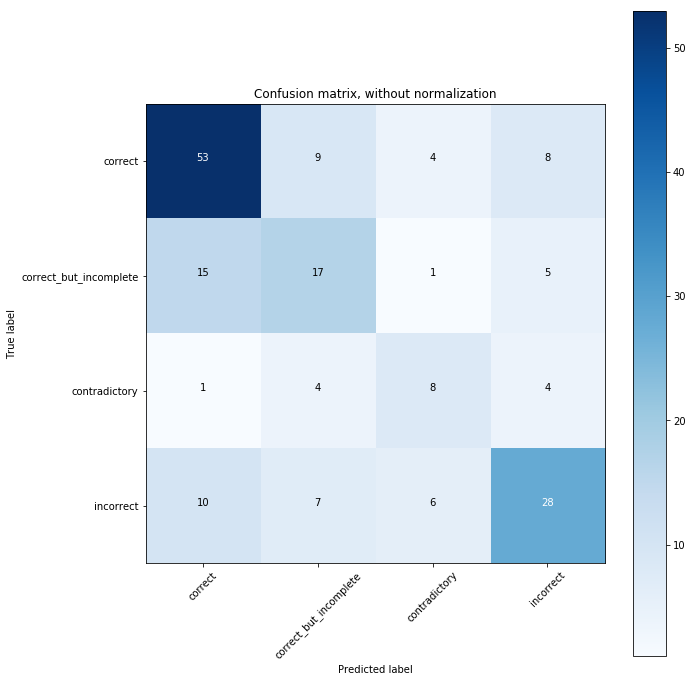

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.Blues)

**Here is an example of how we can draw insights**  
Errors come mainly from "correct" false postive predictions. Many of them are being classified as "incorrect" or "correct_but_incomplete".  
We can use error analysis to examine some instances and come up with new feature engineering ideas that improve the predictions.  
(We need to do this on a validation set and not the final test.)

### Classification Report

In [18]:
# Compute classification report
clf_report = classification_report(y_test, y_hat_test, target_names=class_names)
print(clf_report)

                        precision    recall  f1-score   support

               correct       0.67      0.72      0.69        74
correct_but_incomplete       0.46      0.45      0.45        38
         contradictory       0.42      0.47      0.44        17
             incorrect       0.62      0.55      0.58        51

             micro avg       0.59      0.59      0.59       180
             macro avg       0.54      0.55      0.54       180
          weighted avg       0.59      0.59      0.59       180



Manual error analysis can also be helpful if we need to increase the F-score on the minority classes
("contradictory" and "correct_but_incomplete").

## Optional (Build a conservative system)

Actually, the model generates probabily values for each class.  
But the prediction is coming from the class with the highest probability of belief, even if this probability is low.  
We can think of a system saying "I don't know" every time this probability is below a certain threshold.  
This can help generate more accurate predictions and encourage more data labeling by teachers that can improve training the ML system.

Let's see how the system behaves if we modify the decision threshold that allows the prediction to be sent or not.

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


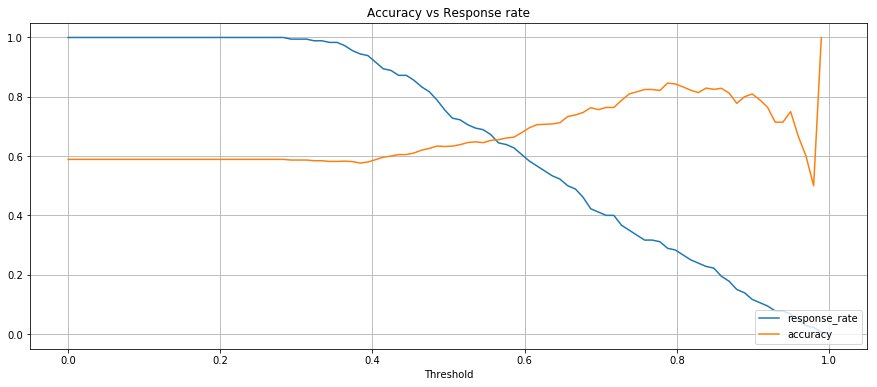

In [20]:
def get_prediction(X, thresh):
    """"Generate class predictions with 99 indicating unknown class."""
    
    pred = model.predict_proba(X)
    pred = [[(class_id, proba) for (class_id, proba) in enumerate(p) if proba == np.max(p)] for p in pred]
    pred = [p[0][0] if p[0][1]>thresh else 99 for p in pred]
    return np.array(pred)

def get_performance(predictions, labels, thresh):
    """Measure the accuracy and the unknown rate depending on the threshold
    
    Args:
        predictions: np.array of class predictions
        label: list of labels
        thresh: distance threshold above which the prediction becomes unknown
        
    Returns:
        accuracy: proportion of correct predictions when not unkown
        unknown_rate: proportion of predictions that are unknown    
    """
    
    # Measure the rate of known predictions
    response_rate = 1 - np.mean(predictions==99)
    
    # Get the indices of predictions to keep
    known_idx = [i for i in range(len(predictions)) if predictions[i]!=99]
    
    # get predictions that are not unknown
    mini_predictions = np.array([predictions[idx] for idx in known_idx])
    mini_labels = np.array([labels[idx] for idx in known_idx])
    
    # Measure the accuracy
    accuracy = np.mean(mini_predictions == mini_labels)
    
    # Ouput dictionary
    output = {'accuracy': accuracy,
              'response_rate': response_rate}
    
    return output


# Plot the performance against the threshold
accuracy = []
response_rate = []
threshold = np.linspace(start = 0, stop = 1, num=100)

for thresh in threshold:
    predictions = get_prediction(X_test, thresh)
    labels = y_test
    perf = get_performance(predictions, labels, thresh)
    accuracy.append(perf['accuracy'])
    response_rate.append(perf['response_rate'])
    
plt.figure(figsize=(15,6))
plt.plot(threshold, response_rate)
plt.plot(threshold, accuracy)
plt.legend(['response_rate', 'accuracy'], loc='lower right')
plt.title('Accuracy vs Response rate')
plt.xlabel('Threshold')
plt.grid(True)
plt.show()

The accuracy could increase up to 90% with a higher decision threshold but the response rate from the system will decrease significantly to 30%.